In [1]:
import sys
import os
from re import split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from dask.distributed import Client, progress
from dask.distributed import Client, LocalCluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
from scipy.special import gamma
from keras.utils.np_utils import to_categorical
import xarray as xr
from matplotlib.colors import ListedColormap
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

In [2]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  # raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
else:
  print(device_name)


Found GPU at: 


2023-08-26 12:29:42.579761: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 12:29:42.585350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-26 12:29:42.585399: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-26 12:29:42.585435: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keeling-j50): /proc/driver/nvidia/version does not exist


In [3]:
cluster = LocalCluster()  
cluster

LocalCluster(6ea4ce66, 'tcp://127.0.0.1:35371', workers=8, threads=48, memory=48.00 GiB)

In [4]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def plot_history(history):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    hist['epoch'] = history.epoch


    ax.set_xlabel('$Epoch$')
    ax.set_ylabel('$Loss$')
    ax.set_title('$Mean \ Absolute \  Error$')
    ax.plot(hist['epoch'], hist['mae'], label='$Training$')
    try:
        ax.plot(hist['epoch'], hist['val_mae'], label='$Validation$')
    except KeyError:
        pass
    # plt.ylim([0,5])
    ax.legend()

    ax1.set_xlabel('$Epoch$')
    ax1.set_ylabel("$Loss$")
    ax1.set_title('$Mean \ Square \ Error$')
    ax1.plot(hist['epoch'], hist['mse'],
             label='$Training$')
    try:
        ax1.plot(hist['epoch'], hist['val_mse'],
                  label='$Validation$')
    except KeyError:
        pass
    # plt.ylim([0,3])
    ax1.legend()
    plt.savefig("../results/loss.jpeg",  bbox_inches="tight")
    plt.show()
    

def metrics_pd(x, xpred):
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return r.sum('diameter')

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [5]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear_corr.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store11 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B_corr.zarr"
store

'/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/zarr/dm_retrieved_Lear_corr.zarr'

In [6]:
dm_lear = xr.open_zarr(store)
dm_p3b = xr.open_zarr(store3)
ds_lear = xr.open_zarr(store1)
ds_lear['altitude'] = ds_lear['altitude'] * 0.3046
ds_lear = ds_lear.drop_sel(time='2019-09-09 00:54:08')
ds_p3b = xr.open_zarr(store2)

/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'gini' loading failed:
cannot import name 'Self' from 'typing_extensions' (/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/typing_extensions.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [7]:
ds_new_lear = xr.merge([dm_lear, ds_lear], compat='override')
ds_new_p3b = xr.merge([dm_p3b, ds_p3b], compat='override')

In [8]:
new_cols = ['dbz_t_ka', 'dbz_t_ku', 'Att_ku', "Att_ka", 'nt', 'lwc_cum', 'mu', 'new_mu', 'mu3', 'mu_bf','sigma', 'sigmap', 'dm', 
            'log10_nw', 'r', 'dfr', 'temp', 'vert_vel', 'altitude','z_ku_mu1', 'z_ku_mu2', 'z_ku_mu3', 'z_ku_mu_bf',
            'z_ka_mu1', 'z_ka_mu2', 'z_ka_mu3', 'z_ka_mu_bf', 'lon', 'lat', 'r', 'r_dm_gm_mu_3', 'r_gpm_operational', 'r_true_nw_mu_dm', 
           'dm_rt_dfr_gm_mu_3', 'dm_rt_dfr_nd_mu_3', 'log10nw_dm_gm_mu_3']

In [9]:
dm_l = ds_new_lear[new_cols]
dm_p = ds_new_p3b[new_cols]
ds = xr.concat([dm_l, dm_p], dim='time')
ds = ds.where(ds.lwc_cum > 0.01, drop=True)

In [10]:
df = ds.to_dataframe()
df = df.reset_index()
df.shape

(8710, 36)

In [11]:
df['dfr'] = df['dbz_t_ku'] - df['dbz_t_ka']
df['dm_class'] = (df.dm > 1.0).astype(int)
df.shape

(8710, 37)

# K-means clustering

In [12]:
df['logr'] = np.log10(df.r)
df['lognt'] = np.log10(df.nt)
df['loglwc'] = np.log10(df.lwc_cum)

cols = ['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]
scaler = StandardScaler()
df[cols]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

n_c = 6
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]
kmeans = KMeans(n_clusters=n_c, random_state=10)
kmeans.fit(X)

df['kmeans_6'] = kmeans.labels_

/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
sns.set(rc={"figure.dpi":120, 'savefig.dpi':120})

In [14]:
# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap6 = ListedColormap(sns.color_palette(flatui).as_hex())

colors6 = my_cmap6(np.linspace(0,1,n_c))

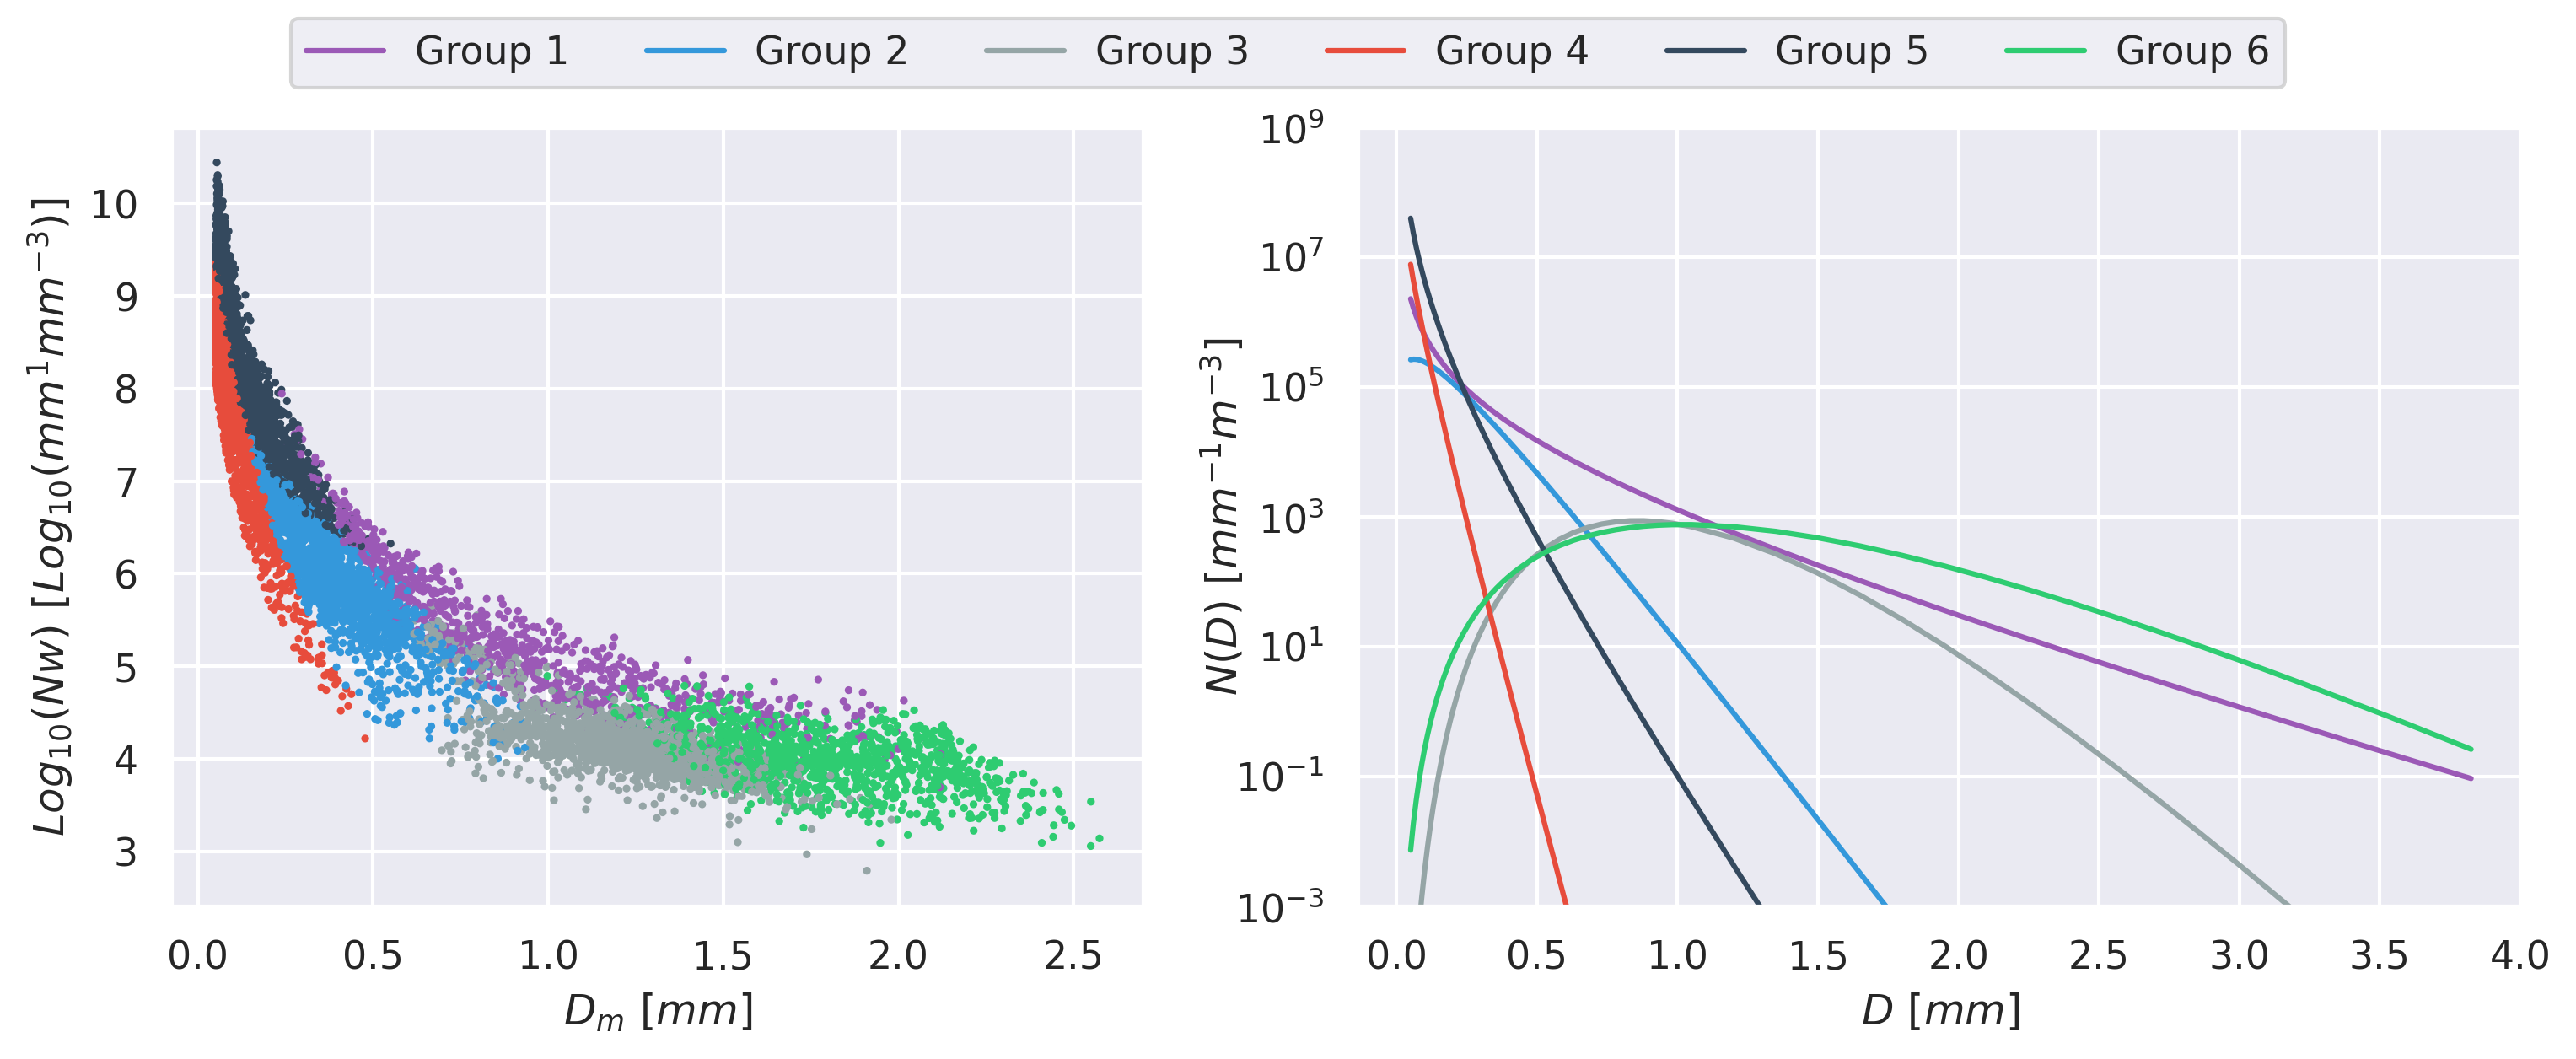

In [41]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=300,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_6'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
# fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].quantile(.50)
    dm = df_sub['dm'].quantile(.50)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(ds_lear.diameter/1000, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)
plt.savefig("../results/kmeans.jpeg",  bbox_inches="tight")

# Load the NN model

In [16]:
model_path = f"{path_data}/cloud_probes/mode/nn_zku_Dfr_temp_ka.h5"
model =  tf.keras.models.load_model(model_path)
# model_path = f"{path_data}/cloud_probes"
# model =  tf.keras.models.load_model(f"{model_path}/E-0251")

In [17]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ka', 'log10_nw', 'dm', 'new_mu']]
# Y = df[['dm_class', 'r', 'kmeans_6', 'time']]
Y = df[['dm_class',  'r', 'kmeans_6', 'time', 'r_dm_gm_mu_3', 'r_gpm_operational', 'r_true_nw_mu_dm', 'dm_rt_dfr_nd_mu_3', 'log10nw_dm_gm_mu_3']]

In [18]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=40, stratify=df.kmeans_6)
X_train.shape

(6532, 7)

In [19]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0].astype(float))
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0.0: 4427, 1.0: 4427})
Testing target statistics: Counter({0: 1476, 1: 702})


In [20]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

2023-08-26 12:29:50.507204: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


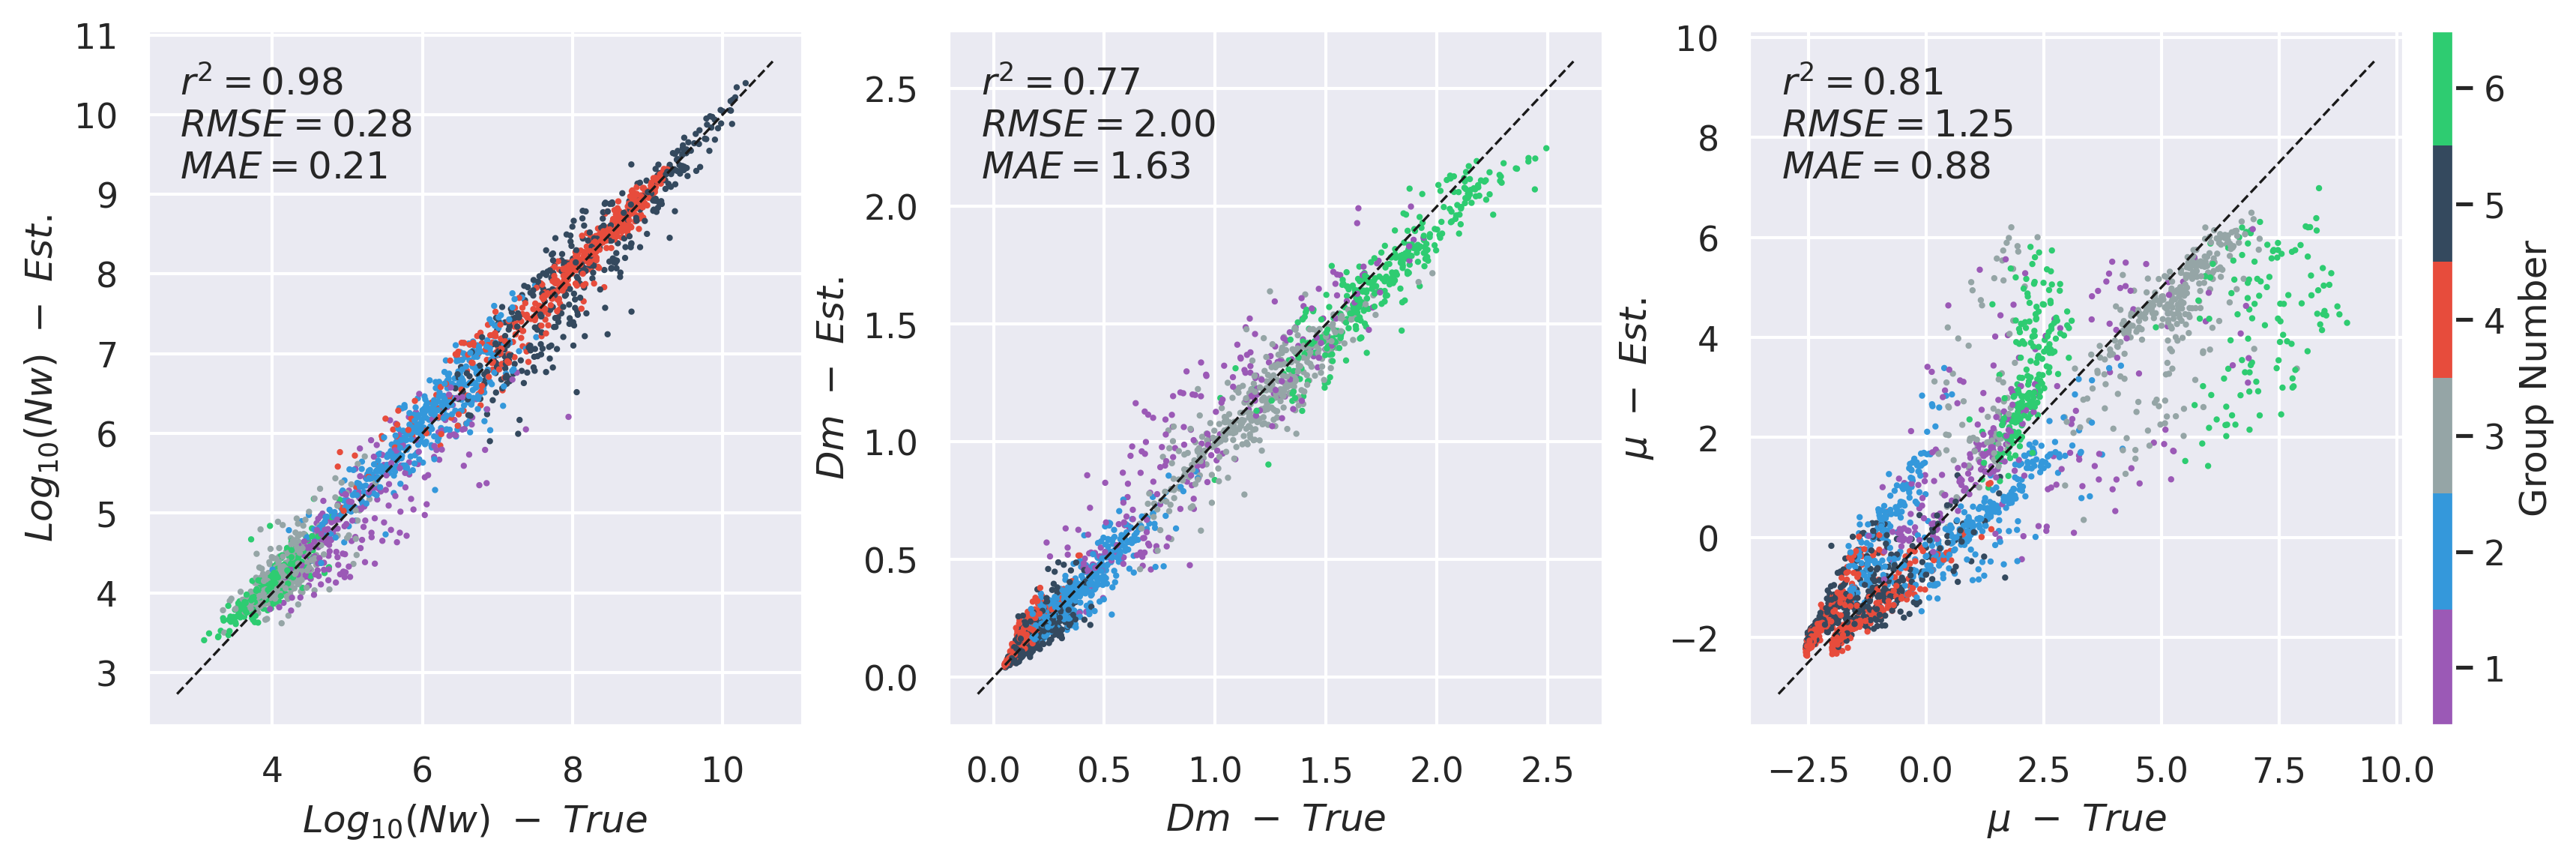

In [39]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4), dpi=300)
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, 2], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, 2], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, 2], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
plt.savefig("../results/params_nn_ka.jpeg",  bbox_inches="tight")

In [22]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu_unc = yhat[:, 2]

ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test[:, -1]),
        diameter=(['diameter'], ds_lear.diameter.values)
    ),
)

d_d = ds_lear.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

ds_sub['nn_gamma_pds'] = norm_gamma(ds_lear.diameter/100, nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm)

nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

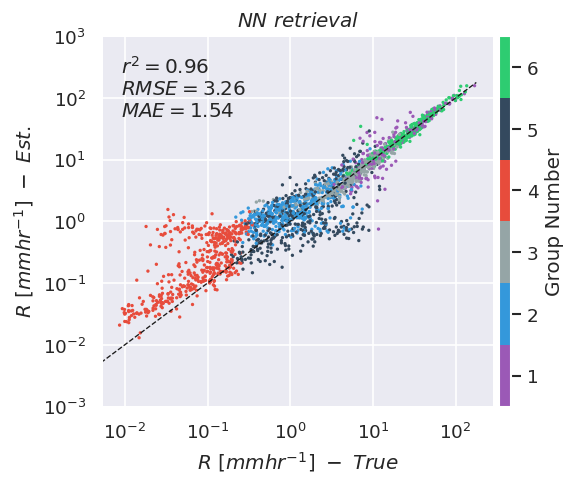

In [29]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 1], nn_rain.values, s=1, c=y_test[:,2 ], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 1], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$NN \ retrieval$")
ax.set_ylim(1e-3, 1e3)
plt.savefig("../results/rr_ka.jpeg",  bbox_inches="tight")

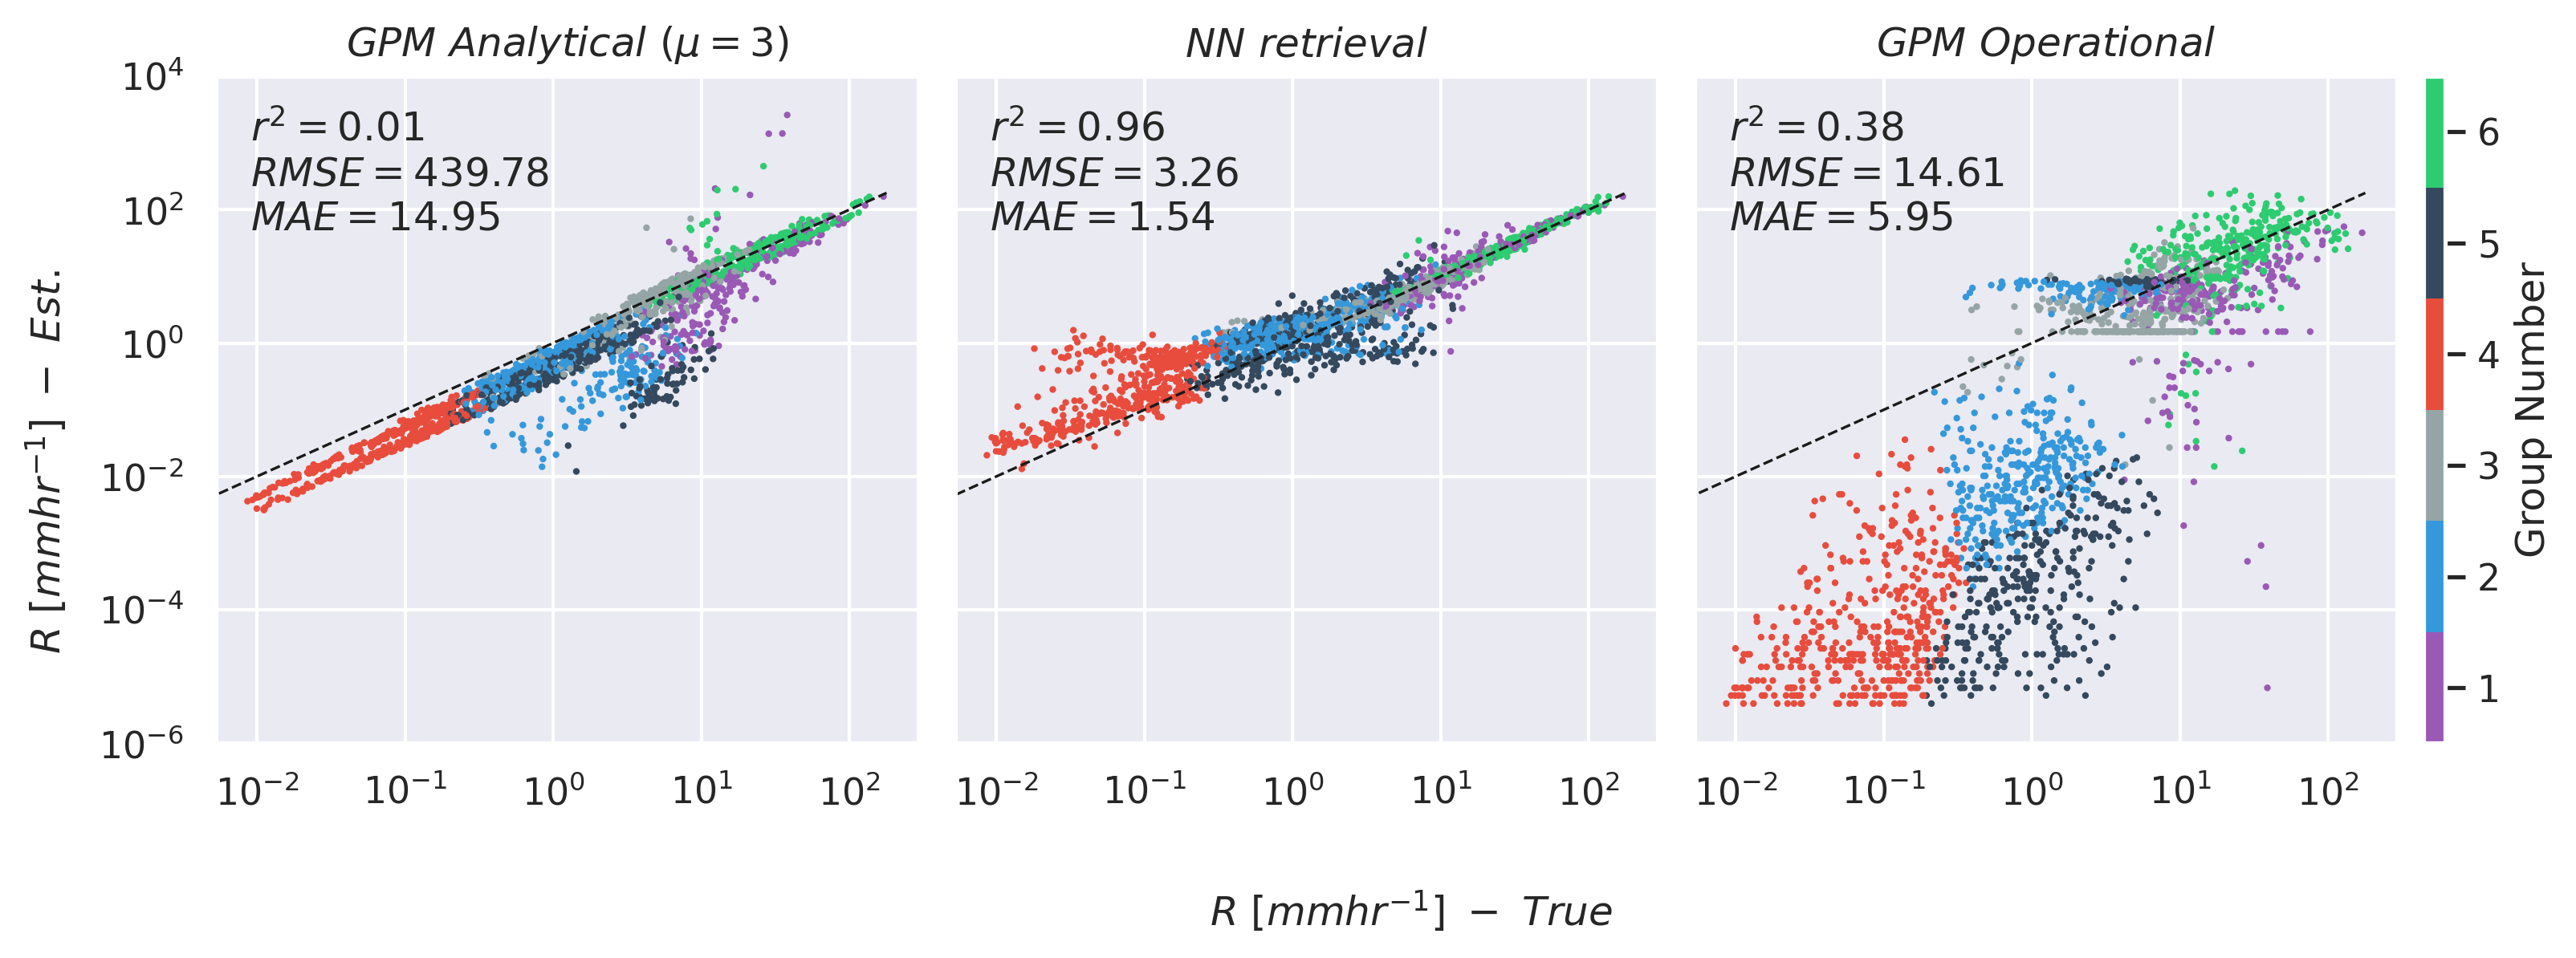

In [38]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax2, ax1) = plt.subplots(1, 3, figsize=(12, 4), sharey=True, dpi=300)

sc1 = ax.scatter(y_test[:, 1], y_test[:, 4], s=1, c=y_test[:, 2], cmap=my_cmap6)
# ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax2.set_ylim(1e-6, 10000)
rmse, mae, corr1 = metrics_pd(y_test[:, 1], y_test[:, 4])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-5, 180)
ax.set_title(r"$GPM \ Analytical \ (\mu=3)$")


sc1 = ax1.scatter(y_test[:, 1], y_test[:, 5], s=1, c=y_test[:, 2], cmap=my_cmap6)
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 1], y_test[:, 5])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title(r"$GPM \ Operational$")

sc1 = ax2.scatter(y_test[:, 1], nn_rain.values, s=1, c=y_test[:, 2], cmap=my_cmap6)
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)

rmse, mae, corr1 = metrics_pd(y_test[:, 1], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, 
        verticalalignment='top')
ax2.set_xscale('log')
ax2.set_yscale('log')
fig.supxlabel(r"$R \ [mmhr^{-1}]\ - \ True $", fontsize=12)
fig.supylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $", fontsize=12)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax,ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax2.set_title(r"$NN \ retrieval$")
plt.savefig("../results/rr_all_log.jpeg",  bbox_inches="tight")

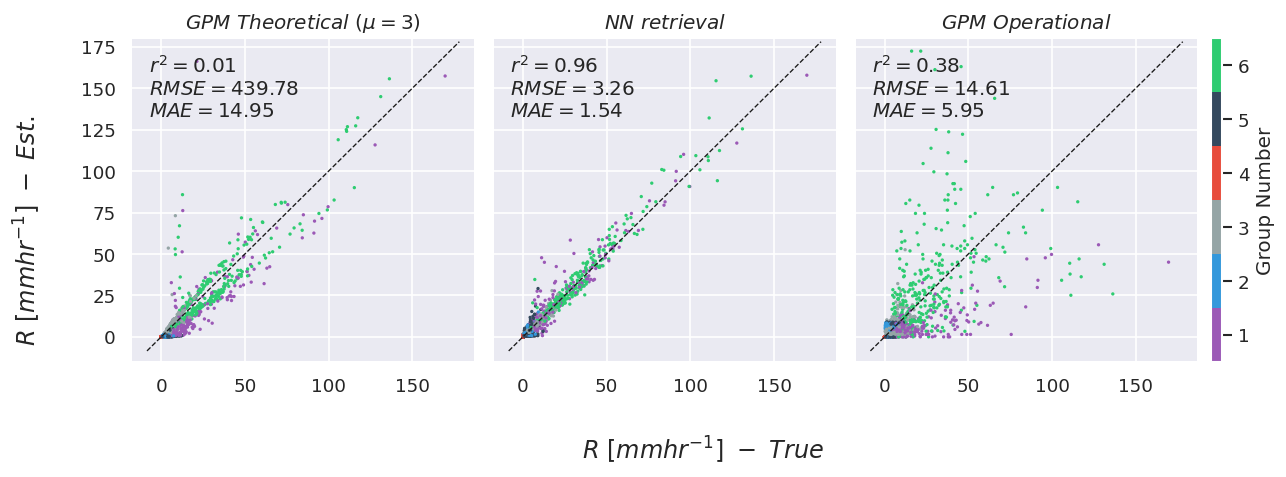

In [25]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax2, ax1) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

sc1 = ax.scatter(y_test[:, 1], y_test[:, 4], s=1, c=y_test[:, 2], cmap=my_cmap6)
# ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax2.set_ylim(1e-6, 10000)
rmse, mae, corr1 = metrics_pd(y_test[:, 1], y_test[:, 4])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(-5, 180)
ax.set_title(r"$GPM \ Theoretical \ (\mu=3)$")


sc1 = ax1.scatter(y_test[:, 1], y_test[:, 5], s=1, c=y_test[:, 2], cmap=my_cmap6)
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 1], y_test[:, 5])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_title(r"$GPM \ Operational$")

sc1 = ax2.scatter(y_test[:, 1], nn_rain.values, s=1, c=y_test[:, 2], cmap=my_cmap6)
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)

rmse, mae, corr1 = metrics_pd(y_test[:, 1], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
# ax2.set_xscale('log')
# ax2.set_yscale('log')
fig.supxlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
fig.supylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax,ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax2.set_title(r"$NN \ retrieval$")
ax.set_ylim(-15, 180)
plt.savefig("../results/rr_all_linear.jpeg",  bbox_inches="tight")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

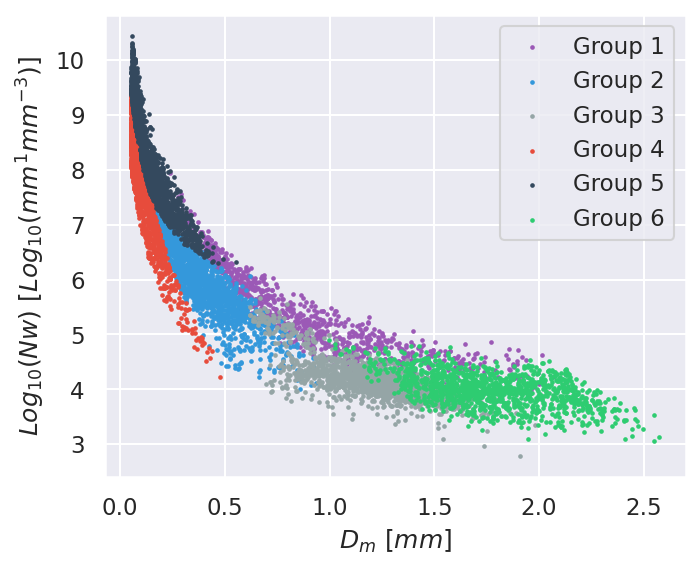

In [26]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)

for i in range(0,6):
    df_sub = df[df['kmeans_6'] == i]
    sc = ax.scatter(df_sub['dm'], df_sub['log10_nw'], s=1.5, c=colors6[i], label=f"Group {i + 1}")
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax.legend()

plt.savefig("../results/scatter_groups.jpeg", bbox_inches="tight")

In [27]:
flatui

['#9b59b6', '#3498db', '#95a5a6', '#e74c3c', '#34495e', '#2ecc71']